# Let's Begin

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import layers, Model
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU

In [4]:
tf.keras.backend.clear_session() 

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

In [7]:
LOW_RES_PATH = "./LR/"
HIGH_RES_PATH = "./HR/"

In [8]:
EPOCHS = 10
BATCH_SIZE = 1
HR_SHAPE = (2040, 2040, 3)
LR_SHAPE = (192, 256, 3)
LEARNING_RATE = 1e-4

In [9]:
def preprocess_image(image_path, target_size):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, target_size)
    image = tf.cast(image, tf.float16) / 127.5 - 1.0  # Normalize to [-1, 1]
    return image

In [10]:
def load_dataset(lr_path, hr_path, lr_shape, hr_shape, batch_size):
    lr_files = tf.data.Dataset.list_files(os.path.join(lr_path, "*.png"), shuffle=True)
    hr_files = tf.data.Dataset.list_files(os.path.join(hr_path, "*.png"), shuffle=True)

    lr_images = lr_files.map(
        lambda x: preprocess_image(x, lr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )
    hr_images = hr_files.map(
        lambda x: preprocess_image(x, hr_shape[:2]), num_parallel_calls=tf.data.AUTOTUNE
    )

    dataset = tf.data.Dataset.zip((lr_images, hr_images))
    dataset = dataset.shuffle(buffer_size=256)  # Reduce shuffle buffer
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
    return dataset

In [ ]:
dataset = load_dataset(LOW_RES_PATH, HIGH_RES_PATH, LR_SHAPE, HR_SHAPE, BATCH_SIZE)

In [ ]:
def build_generator(input_shape=(192, 256, 3)):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolution Block
    x = layers.Conv2D(16, (3, 3), padding="same")(inputs)
    x = layers.PReLU()(x)
    residual = x

    # Residual Blocks
    for _ in range(1):  # Reduced number of residual blocks
        x = layers.Conv2D(16, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.PReLU()(x)
        x = layers.Conv2D(16, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.add([x, residual])

    # Upsampling Layers
    for _ in range(1):  # 3 upscaling layers with block_size=2
        x = layers.Conv2D(16, (3, 3), padding="same")(x)
        x = layers.Lambda(tf.nn.depth_to_space, arguments={'block_size': 2})(x)
        x = layers.PReLU()(x)

    # Final Convolution Block
    x = layers.Conv2D(3, (3, 3), padding="same", activation="tanh")(x)
    x = layers.Lambda(lambda x: tf.image.resize(x, HR_SHAPE[:2]))(x)
    return Model(inputs, x)


generator = build_generator(LR_SHAPE)
generator.summary()

In [ ]:
def build_discriminator(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Blocks
    x = layers.Conv2D(16, (3, 3), strides=1, padding="same")(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)

    for filters in [16, 32]:
        x = layers.Conv2D(filters, (3, 3), strides=2, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)

    # Global Pooling Layer instead of Flatten
    x = layers.GlobalAveragePooling2D()(x)

    # Dense Layers
    x = layers.Dense(32)(x)  # Reduced size
    x = layers.LeakyReLU(alpha=0.2)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs, outputs)

discriminator = build_discriminator(HR_SHAPE)
discriminator.summary()


In [14]:
# Pre-trained VGG model for perceptual loss
vgg = tf.keras.applications.VGG19(include_top=False, weights="imagenet", input_shape=HR_SHAPE)
vgg.trainable = False
vgg = Model(vgg.input, vgg.layers[10].output)  # Use intermediate layer for feature extraction

In [15]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [16]:
def perceptual_loss(hr, sr):
    sr_features = vgg(sr)
    hr_features = vgg(hr)
    return tf.reduce_mean(tf.square(hr_features - sr_features))

In [17]:
# Optimizers
g_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

In [18]:
@tf.function
def train_step(lr_batch, hr_batch):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        fake_hr = generator(lr_batch, training=True)
        
        # Cast both the fake_hr and hr_batch to float32 for loss calculation
        fake_hr = tf.cast(fake_hr, dtype=tf.float32)
        hr_batch = tf.cast(hr_batch, dtype=tf.float32)
        
        # Calculate loss (Example: using L1 loss)
        g_loss = tf.reduce_mean(tf.abs(fake_hr - hr_batch))  # Example loss
        
        # Example of discriminator loss
        d_loss_real = discriminator(hr_batch, training=True)
        d_loss_fake = discriminator(fake_hr, training=True)
        d_loss = 0.5 * (tf.reduce_mean(d_loss_real) + tf.reduce_mean(d_loss_fake))
        
    # Calculate gradients
    gradients_of_generator = tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(d_loss, discriminator.trainable_variables)
    
    # Apply gradients
    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Delete the tape to free resources after use
    del tape

    return d_loss, g_loss

In [19]:
# Training loop
for epoch in range(EPOCHS):
    i=0
    for lr_batch, hr_batch in dataset:
        i+=1
        d_loss, g_loss = train_step(lr_batch, hr_batch)
        print(f"Image: {i}, d_loss: {d_loss:.4f}, g_loss: {g_loss:.4f}", end='\r')

    if epoch % 1 == 0:
        print(f"Epoch {epoch}/{EPOCHS} | D Loss: {d_loss} | G Loss: {g_loss:.4f}")

    # Save model periodically
    if epoch % 1 == 0:
        generator.save(f"generator_epoch_{epoch}.h5")

I0000 00:00:1736345022.442352    9819 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-08 19:33:46.540864: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 334.31MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


2025-01-08 19:43:25.373287: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 0/10 | D Loss: 0.000518798828125 | G Loss: 0.5181


2025-01-08 19:53:01.295357: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/10 | D Loss: 4.57763671875e-05 | G Loss: 0.5006


Epoch 2/10 | D Loss: 0.0 | G Loss: 0.465959


2025-01-08 20:13:54.440814: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 3/10 | D Loss: 0.0 | G Loss: 0.456868


Epoch 4/10 | D Loss: 0.0 | G Loss: 0.482323


Epoch 5/10 | D Loss: 0.0 | G Loss: 0.466464


Epoch 6/10 | D Loss: 0.0 | G Loss: 0.418888


2025-01-08 20:59:29.052969: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 7/10 | D Loss: 0.0 | G Loss: 0.420808


Epoch 8/10 | D Loss: 0.0 | G Loss: 0.534040


Epoch 9/10 | D Loss: 0.0 | G Loss: 0.452020


In [20]:
generator.save("srgan_generator.h5")

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



# Load a low-resolution sample image for prediction
def load_image(path, target_size):
    img = preprocess_image(path, target_size)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Generate predictions
def generate_high_res(model, lr_image):
    prediction = model.predict(lr_image)
    prediction+=1.0
    prediction/=2.0
    prediction = prediction.reshape(HR_SHAPE)
    return prediction

# Visualize the output
def plot_images(lr_image, hr_image):
    print(lr_image.shape)
    # lr_image = lr_image[0]  # Remove batch dimension
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(lr_image)
    axes[0].set_title("Low-Resolution Input")
    axes[0].axis("off")
    
    axes[1].imshow(hr_image)
    axes[1].set_title("High-Resolution Output")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
(192, 256, 3)


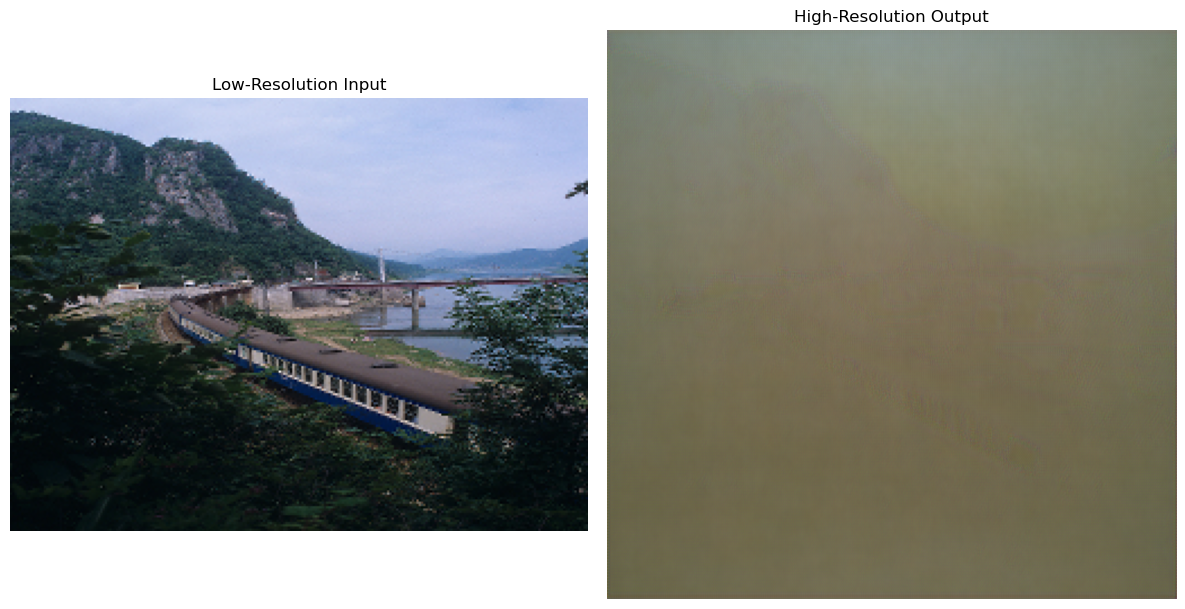

In [80]:
# Path to your low-resolution image
lr_image_path = "LR/0059.png"  # Replace with the actual path
lr_image = load_image(lr_image_path, LR_SHAPE[:2])  # Adjust size as per your model's input

# Generate high-resolution image
hr_image = generate_high_res(generator, lr_image)


lr_image = lr_image.reshape(LR_SHAPE).astype(np.float32)
lr_image+=1.0
lr_image/=2.0
# Plot the images
plot_images(lr_image, hr_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(192, 256, 3)


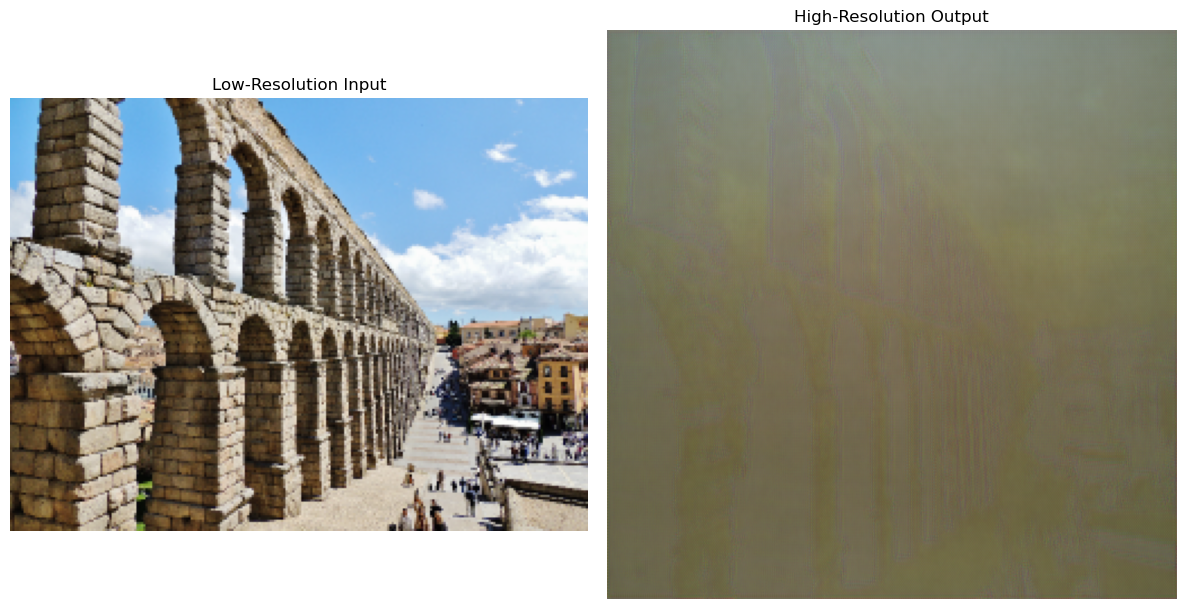

In [81]:
# Path to your low-resolution image
lr_image_path = "LR/0009.png"  # Replace with the actual path
lr_image = load_image(lr_image_path, LR_SHAPE[:2])  # Adjust size as per your model's input

# Generate high-resolution image
hr_image = generate_high_res(generator, lr_image)


lr_image = lr_image.reshape(LR_SHAPE).astype(np.float32)
lr_image+=1.0
lr_image/=2.0
# Plot the images
plot_images(lr_image, hr_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
(192, 256, 3)


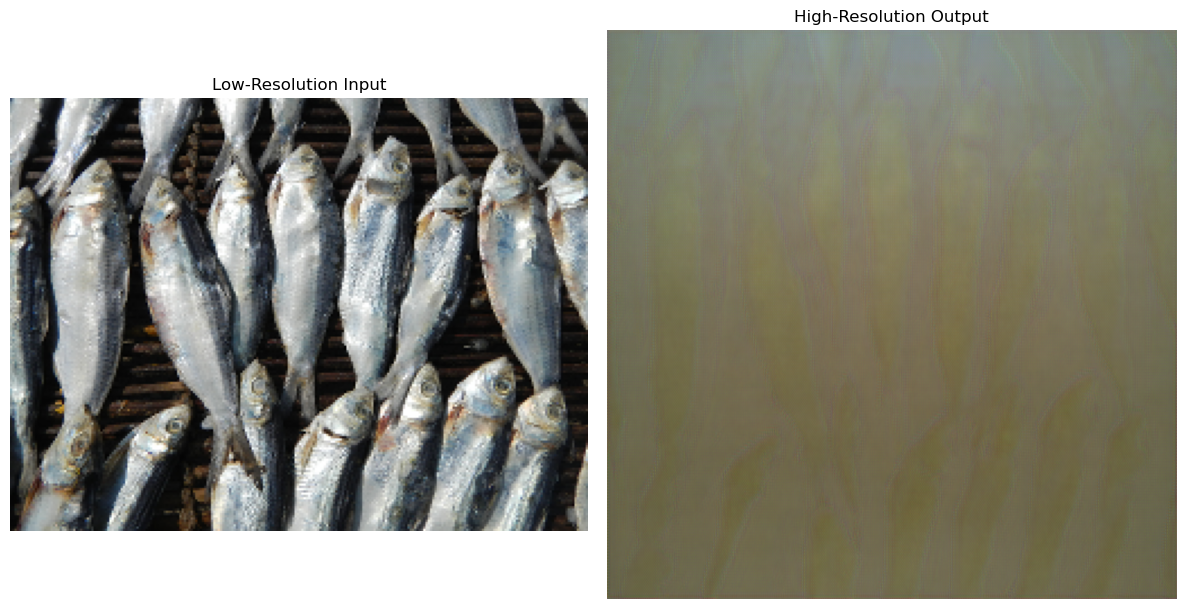

In [83]:
# Path to your low-resolution image
lr_image_path = "LR/0099.png"  # Replace with the actual path
lr_image = load_image(lr_image_path, LR_SHAPE[:2])  # Adjust size as per your model's input

# Generate high-resolution image
hr_image = generate_high_res(generator, lr_image)


lr_image = lr_image.reshape(LR_SHAPE).astype(np.float32)
lr_image+=1.0
lr_image/=2.0
# Plot the images
plot_images(lr_image, hr_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
(192, 256, 3)


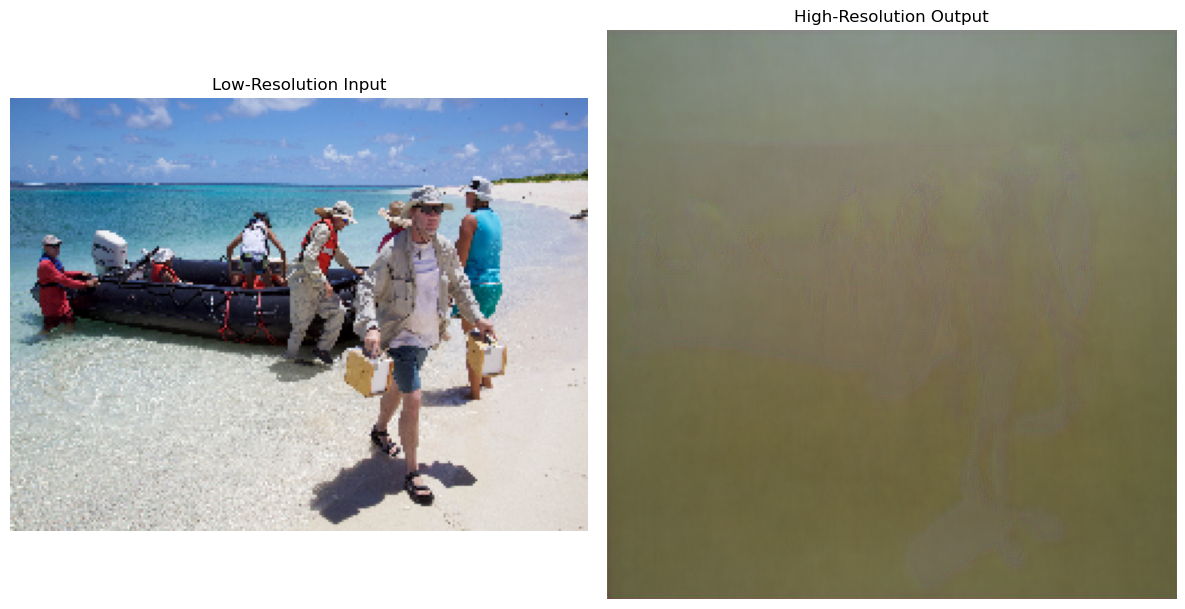

In [84]:
# Path to your low-resolution image
lr_image_path = "LR/0159.png"  # Replace with the actual path
lr_image = load_image(lr_image_path, LR_SHAPE[:2])  # Adjust size as per your model's input

# Generate high-resolution image
hr_image = generate_high_res(generator, lr_image)


lr_image = lr_image.reshape(LR_SHAPE).astype(np.float32)
lr_image+=1.0
lr_image/=2.0
# Plot the images
plot_images(lr_image, hr_image)
